# Calibration of the school model with age dependence based on empirical data

In [5]:
import numpy as np
import pandas as pd
import numpy as np
from os.path import join
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

# custom functions to run the calibration simulations
import calibration_functions as cf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

## Empirical observations

In [80]:
# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

In [81]:
empirical_data_src = '../../data/calibration/empirical_observations'

# distribution of outbreak sizes by school type
outbreak_sizes = pd.read_csv(\
            join(empirical_data_src, 'empirical_outbreak_sizes.csv'))
# ratio of infections in the student and teacher groups
group_distributions = pd.read_csv(\
            join(empirical_data_src, 'empirical_group_distributions.csv'))
# ratio of index cases in the student and teacher groups
agent_index_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_index_case_ratios.csv'))
agent_index_ratios.index = agent_index_ratios['school_type']
# ratio of symptomatic cases in the student and teacher groups
symptomatic_case_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_symptomatic_case_ratios.csv'))

In [82]:
# note: these are the number of clusters per school type from the slightly older
# data version (November 2020). For primary and lower secondary school types,
# the counts are split evenly between schools with and without daycare. 
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary'],
                      'count':[33.5, 33.5, 90, 90, 116, 70]})

counts.index = counts['type']
counts = counts.drop(columns=['type'])
# The cluster counts are used to weigh the respective school type in the 
# calibration process.
counts['weight'] = counts['count'] / counts['count'].sum()

## Simulation settings

In [83]:
# List of prevention measures that were in place in schools in the weeks 36-45
# of the year 2020 in Austrian schools. This list was compiled from information
# collected in interviews with teachers of different school types. NOTE: so far
# there are no recorded differences between school types.
with open('params/calibration_measures.json', 'r') as fp:
    prevention_measures = json.load(fp)
# simulation parameters, specifically the
# - base transmission risk (calibrated from household transmissions)
# - subclinical transmission modifier (literature value)
# - exposure duration, time until symtpoms and infection duration (lit. values)
# - age symptom discount (fit to empirical observations)
with open('params/calibration_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
# characteristics (# classes, # students / class, # teachers) of the "average" 
# school, depending on school type. These characteristics were determined in 
# interviews with Austrian teachers and from statistics about Austrian schools 
# (year 2017/18, page 10: https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html)
# NOTE: "students" indicates the number of students per class
with open('params/calibration_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

## Simulation function

In [84]:
def run(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters test_type, 
        index_case, e_screen_range and r_screen_range that are passed to the
        simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, intermediate_contact_weight, far_contact_weight,\
                age_transmission_discount = params

    # run the ensemble with the given parameter combination and school type
    ensemble_results = cf.run_ensemble(N_runs, school_type,
            intermediate_contact_weight, far_contact_weight, 
            age_transmission_discount, prevention_measures,
            school_characteristics, agent_index_ratios,
            simulation_params, contact_network_src, ensmbl_dst)

    # calculate the difference between the ensemble characteristics
    # (outbreak distribution, ratio of student to teacher cases)
    row = cf.evaluate_ensemble(ensemble_results, school_type,
            intermediate_contact_weight, far_contact_weight,
            age_transmission_discount, outbreak_sizes, group_distributions)
    
    return row

## Coarse grid search with age dependence

### Create calibration parameter grid

In [85]:
# optimum far contact weight from a quick coarse calibration without age 
# dependence as best starting guess to center the parameter grid. See script 
# calibration_without_age_dependence.ipyn
opt_contact_weight_prev = 0.27

In [86]:
## grid of parameters that need to be calibrated
N_runs = 500

# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search, passed to the script via the command line.
contact_weights_coarse = np.hstack([
    np.arange(opt_contact_weight_prev - 0.05, 
              opt_contact_weight_prev, 0.01),
    np.arange(opt_contact_weight_prev, 
              opt_contact_weight_prev + 0.06, 0.01)
    ])

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced. Parameter values are chosen around the optimum 
# from the previous random sampling search
age_transmission_discounts_coarse = [-0.01,-0.02,-0.03,-0.04,-0.05,-0.06, 
                                   -0.07, -0.08, -0.09]

contact_weights_fine = np.asarray([round(i, 2) \
            for i in contact_weights_coarse])


print('contact weights: ', contact_weights_coarse)
print('age discounts: ', age_transmission_discounts_coarse)

# list of all possible parameter combinations from the grid
# Note: the age transmission discount is set to 0 for all parameter
# combinations here
screening_params = [(N_runs, i, j, j, k) for i in school_types \
                    for j in contact_weights_coarse \
                    for k in age_transmission_discounts_coarse]

print('There are {} parameter combinations to sample.'.format(len(screening_params)))

contact weights:  [0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32]
age discounts:  [-0.01, -0.02, -0.03, -0.04, -0.05, -0.06, -0.07, -0.08, -0.09]
There are 594 parameter combinations to sample.


### Run the sampling

Note: since running the calibration is computationally rexpensive, the below function is best run on a server or cluster. See the script `calibration_coarse.py` that was used to generate results for this calibration step on a cluster.

In [109]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles_coarse'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params),
                total=len(screening_params)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_coarse_sampling_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 600/600 [19:54:15<00:00, 119.43s/it]    


CPU times: user 7.04 s, sys: 1.41 s, total: 8.45 s
Wall time: 19h 54min 17s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.26,0.25,0.0,0.089444,0.054324,0.143768,0.132040,0.068568,0.200608
1,primary,0.25,0.24,0.0,0.059658,0.066652,0.126310,0.088069,0.083824,0.171893
2,primary,0.25,0.21,0.0,0.078605,0.120814,0.199419,0.116039,0.154010,0.270049


### Analyze the fine grid search

#### Collect the results

Note: if results are produced on a cluster and saved in school-specific files, files have to be combined to one big table first before they are loaded here.

In [87]:
dst = '../../data/calibration/simulation_results'
N = 2000
results_coarse = pd.read_csv(join(dst, 'calibration_results_coarse_sampling_{}.csv'\
                        .format(N)))

In [88]:
results_coarse = results_coarse.sort_values(by=['school_type',
                    'intermediate_contact_weight', 'age_transmission_discount'])
results_coarse = results_coarse.reset_index(drop=True)

results_coarse['chi2_distance_total'] = \
        results_coarse['chi2_distance_size'] + \
        results_coarse['sum_of_squares_distro']

results_coarse['chi2_distance_total_weighted'] = \
        results_coarse['chi2_distance_total']

for i, row in results_coarse.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results_coarse.loc[i, 'chi2_distance_total_weighted'] = error * weight

#### Aggretage results

In [89]:
agg_results_coarse = results_coarse.groupby(['intermediate_contact_weight',
                                         'age_transmission_discount']).sum()
opt_coarse = agg_results_coarse.loc[\
        agg_results_coarse['chi2_distance_total_weighted'].idxmin()].name
opt_contact_weight_coarse = opt_coarse[0]
opt_age_transmission_discount_coarse = opt_coarse[1]

print('optimal grid search parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_contact_weight_coarse))
print('\t age transmission discount: {:1.3f}'\
      .format(opt_age_transmission_discount_coarse))

optimal grid search parameter combination:
	 intermediate contact weight: 0.290
	 age transmission discount: -0.010


In [90]:
img_coarse = np.zeros((len(contact_weights_coarse),
                len(age_transmission_discounts_coarse)))
for i, cw in enumerate(contact_weights_coarse):
    for j, atd in enumerate(age_transmission_discounts_coarse):
        cw = round(cw, 2)
        atd = round(atd, 2)
        try:
            img_coarse[i, j] = agg_results_coarse\
                .loc[cw, atd]['chi2_distance_total_weighted']
        except KeyError:
            img_coarse[i, j] = np.nan

#### Plot results

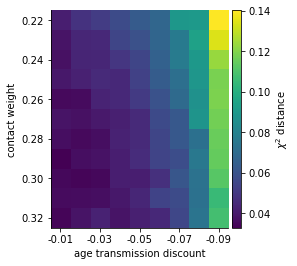

In [91]:
fig, ax = plt.subplots(figsize=(6, 4))

im = ax.imshow(img_coarse)
ax.set_yticks(range(len(contact_weights_fine))[::2])
ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                    cw in contact_weights_fine[::2]])
ax.set_xticks(range(len(age_transmission_discounts_coarse))[::2])
ax.set_xticklabels(['{:1.2f}'.format(atd) for \
                    atd in age_transmission_discounts_coarse[::2]])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('$\chi^2$ distance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('contact weight')
ax.set_xlabel('age transmission discount');

## Fine grid search with age dependence

### Create the parameter grid

In [170]:
N_runs = 4000

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search, passed to the script via the command line.
contact_weights_fine = np.hstack([
    np.arange(opt_contact_weight_coarse - 0.06, 
              opt_contact_weight_coarse, 0.01),
    np.arange(opt_contact_weight_coarse, 
              opt_contact_weight_coarse + 0.061, 0.01)
    ])

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced. Parameter values are chosen around the optimum 
# from the previous random sampling search
age_transmission_discounts_fine = [0.00, -0.0025, -0.005, -0.0075, -0.01,
                                   -0.0125, -0.015, -0.0175, -0.02,
                                   -0.0225, -0.025, -0.0275, -0.03]

contact_weights_fine = np.asarray([round(i, 2) \
            for i in contact_weights_fine])


print('contact weiths: ', contact_weights_fine)
print('age discounts: ', age_transmission_discounts_fine)

# list of all possible parameter combinations from the grid
# Note: the age transmission discount is set to 0 for all parameter
# combinations here
screening_params = [(N_runs, i, j, j, k) for i in school_types \
                    for j in contact_weights_fine \
                    for k in age_transmission_discounts_fine]


print('There are {} parameter combinations to sample with {} runs each.'\
  .format(len(screening_params), N_runs))

contact weiths:  [0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35]
age discounts:  [0.0, -0.0025, -0.005, -0.0075, -0.01, -0.0125, -0.015, -0.0175, -0.02, -0.0225, -0.025, -0.0275, -0.03]
There are 1014 parameter combinations to sample with 4000 runs each.


### Run the sampling

Note: since running the calibration is computationally rexpensive, the below function is best run on a server or cluster. See the script `calibration_fine.py` that was used to generate results for this calibration step on a cluster.

In [59]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles_fine'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params[0:10]),
                total=len(screening_params)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_fine_sampling_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

  1%|          | 10/864 [00:01<01:26,  9.87it/s]


CPU times: user 104 ms, sys: 72.6 ms, total: 176 ms
Wall time: 1.19 s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.24,0.24,-0.0125,NaN,0.142476,NaN,NaN,0.176209,NaN
1,primary,0.24,0.24,-0.0150,0.131197,0.452821,0.584017,0.193677,0.579194,0.772871
2,primary,0.24,0.24,-0.0225,0.048298,0.564163,0.612461,0.071299,0.698597,0.769896


### Analyze the fine grid search for all distance metrics

#### Collect ensemble results

In [ ]:
# Note: do not run again if ensemble distributions have already been calculated

# calculate the number of infected students and teachers for every run in
# the given ensemble and save them for later analysis
src = '../../data/calibration/simulation_results/ensembles_fine'
dst = '../../data/calibration/simulation_results/ensembles_fine_ensemble_distributions'

for i, ep in enumerate(screening_params):
    if i % 10 == 0:
        print('{}/{}'.format(i, len(screening_params)))
    cf.calculate_ensemble_distributions(ep, src, dst)

#### Calculate distance metrics overall distribution + ratio

In [172]:
# calculate the various distribution distances between the simulated and
# observed outbreak size distributions
src = '../../data/calibration/simulation_results/ensembles_fine_ensemble_distributions'

results_fine = pd.DataFrame()
for i, ep in enumerate(screening_params):
    _, school_type, icw, fcw, atd = ep
    if i % 100 == 0:
        print('{}/{}'.format(i, len(screening_params)))
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
        .format(school_type, icw, fcw, atd)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    row = cf.calculate_distances(ensemble_results, school_type, icw, fcw, atd,
                       outbreak_sizes, group_distributions)
    
    results_fine = results_fine.append(row, ignore_index=True)

0/1014
100/1014
200/1014
300/1014
400/1014
500/1014
600/1014
700/1014
800/1014
900/1014
1000/1014


In [176]:
# collection of different distance metrics to try
distance_cols = [
    'sum_of_squares',
    'chi2_distance',
    'bhattacharyya_distance',
    'spearmanr_difference',
    'pearsonr_difference',
    'pp_difference',
    'qq_difference',
]

In [177]:
results_fine = results_fine.sort_values(by=['school_type',
                'intermediate_contact_weight', 'age_transmission_discount'])
results_fine = results_fine.reset_index(drop=True)

for col in distance_cols:
    results_fine[col + '_total'] = results_fine[col + '_size'] + \
                    results_fine['sum_of_squares_distro']
    results_fine[col + '_total_weighted'] = results_fine[col + '_total']
    
    for i, row in results_fine.iterrows():
        st = row['school_type']
        weight = counts.loc[st, 'weight']
        error = row[col + '_total']
        results_fine.loc[i, col + '_total_weighted'] = error * weight

#### Aggretage results

In [178]:
agg_results_fine = results_fine\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount'])\
    .sum()

for col in distance_cols:
    print(col)
    opt_fine = agg_results_fine.loc[\
            agg_results_fine[col + '_total_weighted'].idxmin()].name
    opt_contact_weight_fine = opt_fine[0]
    opt_age_transmission_discount_fine = opt_fine[1]

    print('optimal grid search parameter combination:')
    print('\t contact weight: {:1.3f}'\
          .format(opt_contact_weight_fine))
    print('\t age transmission discount: {:1.4f}'\
          .format(opt_age_transmission_discount_fine))
    print()

sum_of_squares
optimal grid search parameter combination:
	 contact weight: 0.260
	 age transmission discount: 0.0000

chi2_distance
optimal grid search parameter combination:
	 contact weight: 0.330
	 age transmission discount: -0.0075

bhattacharyya_distance
optimal grid search parameter combination:
	 contact weight: 0.240
	 age transmission discount: -0.0025

spearmanr_difference
optimal grid search parameter combination:
	 contact weight: 0.230
	 age transmission discount: -0.0075

pearsonr_difference
optimal grid search parameter combination:
	 contact weight: 0.290
	 age transmission discount: -0.0150

pp_difference
optimal grid search parameter combination:
	 contact weight: 0.270
	 age transmission discount: 0.0000

qq_difference
optimal grid search parameter combination:
	 contact weight: 0.350
	 age transmission discount: -0.0175



In [179]:
# compose matrices of the distance measurements for all different distance
# metrics which are calculated as sum between the first component (ratio of
# infected students and teachers) and the second component (outbreak size
# distribution)
distance_images = {}
for col in distance_cols:
    img_fine = np.zeros((len(contact_weights_fine),
                    len(age_transmission_discounts_fine)))
    for i, cw in enumerate(contact_weights_fine):
        for j, atd in enumerate(age_transmission_discounts_fine):
            cw = round(cw, 2)
            atd = round(atd, 4)
            try:
                img_fine[i, j] = agg_results_fine\
                    .loc[cw, atd][col + '_total_weighted']
            except KeyError:
                print(atd)
                img_fine[i, j] = np.nan
    distance_images[col] = img_fine

In [180]:
# extract only the error component that is caused by the ratio of infected
# students and teacher
img_first_component = np.zeros((len(contact_weights_fine),
                len(age_transmission_discounts_fine)))
for i, cw in enumerate(contact_weights_fine):
    for j, atd in enumerate(age_transmission_discounts_fine):
        cw = round(cw, 2)
        atd = round(atd, 4)
        try:
            img_first_component[i, j] = agg_results_fine\
                .loc[cw, atd]['sum_of_squares_distro']
        except KeyError:
            print(atd)
            img_first_component[i, j] = np.nan


#### Plots

##### First distance component

Note: this is an additional analysis that is not included in the paper.

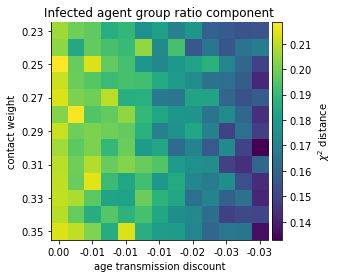

In [181]:
fig, ax = plt.subplots(figsize=(6, 4))

im = ax.imshow(img_first_component)
ax.set_yticks(range(len(contact_weights_fine))[::2])
ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                    cw in contact_weights_fine[::2]])
ax.set_xticks(range(len(age_transmission_discounts_fine))[::2])
ax.set_xticklabels(['{:1.2f}'.format(atd) for \
                    atd in age_transmission_discounts_fine[::2]])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('$\chi^2$ distance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('contact weight')
ax.set_xlabel('age transmission discount')
ax.set_title('Infected agent group ratio component')

plt.savefig('../../data/plots/calibration/first_component.pdf')

##### Figure S1: Sum of distance components

In [186]:
# qq and spearman are super noisy, exclude them for further analysis
distance_col_names = {
    'sum_of_squares':'Sum of squares',
    'chi2_distance':'$\\chi^2$',
    'bhattacharyya_distance':'Bhattacharyya',
    'spearmanr_difference': 'Spearman correlation',
    'pearsonr_difference':'Pearson correlation',
    'pp_difference':'pp-slope',
    'qq_difference':'qq-slope'
}

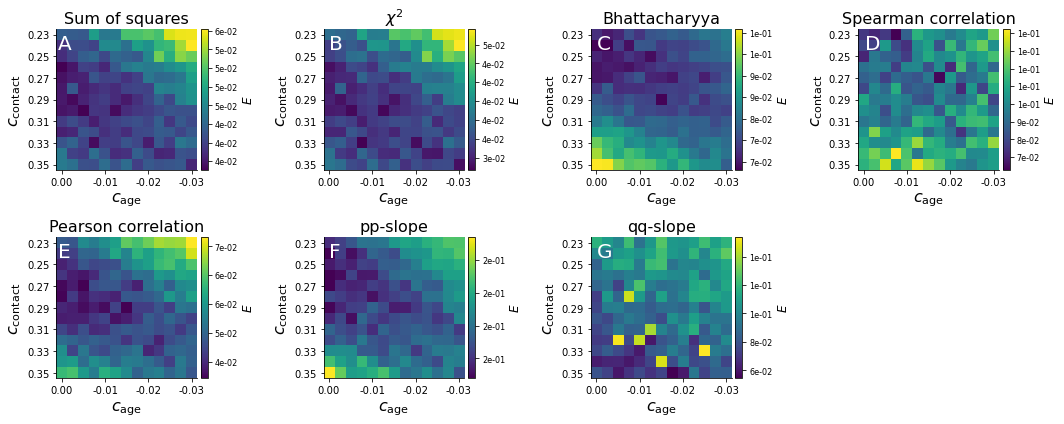

In [223]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

for ax, col in zip(axes.flatten(), distance_col_names.keys()):
    img_fine = distance_images[col]
    im = ax.imshow(img_fine)
    ax.set_yticks(range(len(contact_weights_fine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_fine[::2]])
    #ax.set_xticks(range(len(age_transmission_discounts_fine))[::2])
    ax.set_xticks([0, 4, 8, 12])
    ax.set_xticklabels(['0.00', '-0.01', '-0.02', '-0.03'])
    #ax.set_xticklabels(['{:1.4f}'.format(atd) for \
    #                    atd in age_transmission_discounts_fine[::2]],
    #                    fontsize=8)
    ax.set_title(distance_col_names[col], fontsize=16)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', format='%.0e')
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('$E$', fontsize=12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('$c_\\mathrm{contact}$', fontsize=16)
    ax.set_xlabel('$c_\\mathrm{age}$', fontsize=16)

axes[1, 3].axis('off')

fig.text(0.061, 0.875, 'A', color='w', fontsize=20)
fig.text(0.312, 0.875, 'B', color='w', fontsize=20)
fig.text(0.56, 0.875, 'C', color='w', fontsize=20)
fig.text(0.808, 0.875, 'D', color='w', fontsize=20)
fig.text(0.061, 0.395, 'E', color='w', fontsize=20)
fig.text(0.312, 0.395, 'F', color='w', fontsize=20)
fig.text(0.56, 0.395, 'G', color='w', fontsize=20)

fig.tight_layout()
plt.savefig('../../data/plots/calibration/distances_heatmap.pdf')

##### Chi² distance for individual school types

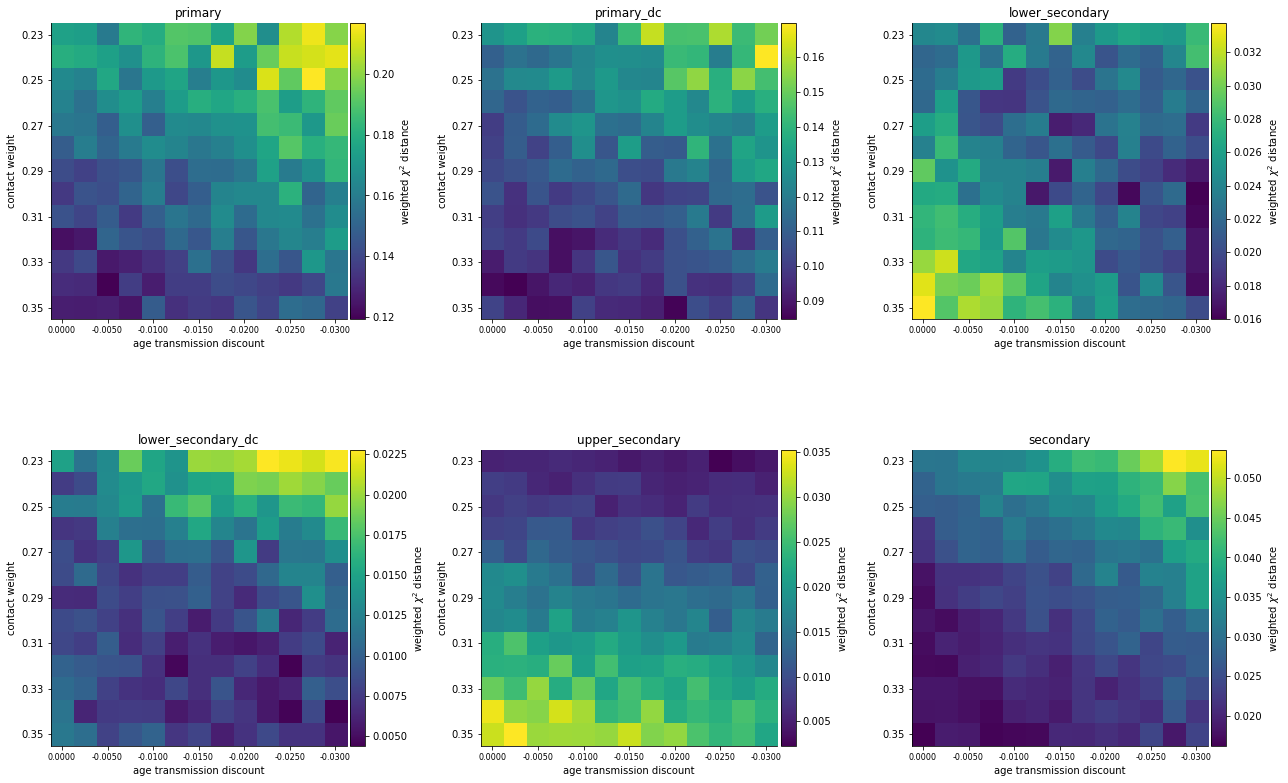

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

results_fine_indexed = results_fine.set_index(['school_type', 
                    'intermediate_contact_weight', 'age_transmission_discount'])

for st, ax in zip(school_types, axes.flatten()):
    
    img_st = np.zeros((len(contact_weights_fine),
                len(age_transmission_discounts_fine)))
    for i, cw in enumerate(contact_weights_fine):
        for j, atd in enumerate(age_transmission_discounts_fine):
            cw = round(cw, 2)
            atd = round(atd, 4)
            try:
                img_st[i, j] = results_fine_indexed\
                    .loc[st, cw, atd]['chi2_distance_total']
            except KeyError:
                print(atd)
                img_st[i, j] = np.nan
    
    im = ax.imshow(img_st)
    ax.set_yticks(range(len(contact_weights_fine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_fine[::2]])
    ax.set_xticks(range(len(age_transmission_discounts_fine))[::2])
    ax.set_xticklabels(['{:1.4f}'.format(atd) for \
                        atd in age_transmission_discounts_fine[::2]],
                        fontsize=8)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('weighted $\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('contact weight')
    ax.set_xlabel('age transmission discount')
    ax.set_title(st)
fig.tight_layout()
plt.savefig('../../data/plots/calibration/error_term_heatmaps_schooltypes.pdf')

##### Chi² distances as lineplots

atd: 0.0000, min: 0.0333, cw: 0.2600
atd: -0.0025, min: 0.0333, cw: 0.2900
atd: -0.0050, min: 0.0330, cw: 0.3000
atd: -0.0075, min: 0.0327, cw: 0.3300
atd: -0.0100, min: 0.0347, cw: 0.3200
atd: -0.0125, min: 0.0329, cw: 0.3000
atd: -0.0150, min: 0.0335, cw: 0.2900
atd: -0.0175, min: 0.0347, cw: 0.2900
atd: -0.0200, min: 0.0332, cw: 0.3300
atd: -0.0225, min: 0.0336, cw: 0.3400
atd: -0.0250, min: 0.0336, cw: 0.3400
atd: -0.0275, min: 0.0352, cw: 0.3200
atd: -0.0300, min: 0.0333, cw: 0.3500


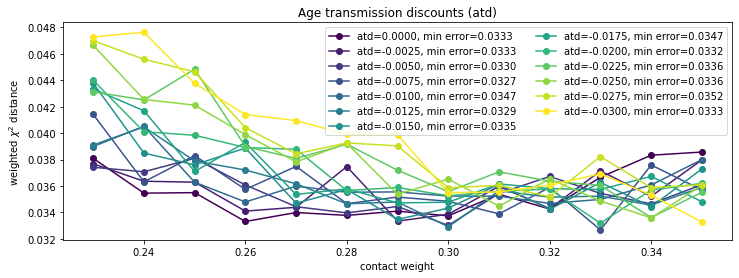

In [25]:
agg_results_selection_fine = agg_results_fine.copy().reset_index()

fig, ax = plt.subplots(figsize=(12,4))
cmap = plt.get_cmap('viridis')

for i, atd_level in enumerate(age_transmission_discounts_fine):
    atd_level = round(atd_level, 4)
    agg_results_level = agg_results_selection_fine[\
        agg_results_selection_fine['age_transmission_discount'] == atd_level]\
        .reset_index(drop=True)
    
    ax.plot(agg_results_level['contact_weight'],
            agg_results_level['chi2_distance_total_weighted'],
            'o-', color=cmap(i/(len(contact_weights_fine) - 1)),
            label='atd={:1.4f}, min error={:1.4f}'\
                .format(atd_level, agg_results_level['chi2_distance_total_weighted'].min()))
    
    min_cw = agg_results_level.loc[agg_results_level['chi2_distance_total_weighted'].idxmin()]['contact_weight']
    print('atd: {:1.4f}, min: {:1.4f}, cw: {:1.4f}'\
          .format(atd_level, agg_results_level['chi2_distance_total_weighted'].min(), min_cw))
    
ax.set_ylabel('weighted $\chi^2$ distance')
ax.set_xlabel('contact weight')
ax.legend(ncol=2, loc=0)
ax.set_title('Age transmission discounts (atd)')
plt.savefig('../../data/plots/calibration/error_term_lineplot.pdf');

##### Plane fitted through Chi² distances

In [28]:
%matplotlib widget
import scipy
data = agg_results_fine[['chi2_distance_total_weighted']].reset_index().values

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(data[0:,0].min() - 0.025, data[0:,0].max() + 0.025, 0.01),
                  np.arange(data[0:,1].min(), data[0:,1].max() + 0.001, 0.001))
XX = X.flatten()
YY = Y.flatten()

A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
# evaluate it on a grid
Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='b', s=10)

intermediate_opt, far_opt = np.unravel_index(Z.argmin(), Z.shape)
intermediate_range = np.arange(data[0:,0].min() - 0.05, data[0:,0].max() + 0.05, 0.01)
far_range = np.arange(data[0:,1].min() - 0.05, data[0:,1].max() + 0.05, 0.01)

#ax.scatter([intermediate_range[intermediate_opt]], [far_range[far_opt]],
#           [Z.min()], c='b', s=30)
#ax.scatter(data[0, 0], data[0, 1], data[0, 2], c='b', s=30)
ax.scatter(XX[np.argmin(Z)], YY[np.argmin(Z)], Z.min(), s=50, c='r')

print('min: ({:1.4f}, {:1.4f}, {:1.4f})'.format(XX[np.argmin(Z)], YY[np.argmin(Z)], Z.min()))

plt.xlabel('contact weight')
plt.ylabel('age transmission modification')
ax.set_zlabel('error term')
#ax.axis('equal')
#ax.axis('tight')
plt.show()
plt.savefig('../../data/plots/calibration/error_term_surfaceplot.pdf');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

min: (0.2850, 0.0000, 0.0342)


### Bootstrapping for sum-of-squares distance

#### Run the bootstrapping

In [2]:
def run_bootstrap(params):
    src = '../../data/calibration/simulation_results/ensembles_fine_ensemble_distributions'
    ensemble_results, st, icw, fcw, atd, outbreak_sizes, \
    group_distributions, bootstrap_run = params
    
    row = cf.calculate_distances(ensemble_results, st, icw, fcw, atd,
                       outbreak_sizes, group_distributions)
    
    row.update({'bootstrap_run':bootstrap_run})
    
    return row

In [ ]:
# calculate the various distribution distances between the simulated and
# observed outbreak size distributions. Note: 

dst = '../../data/calibration/simulation_results/'
N_bootstrap = 1000 # number of subsamplings per parameter combination

bootstrapping_results = pd.DataFrame()
for i, ep in enumerate(screening_params):
    _, school_type, icw, fcw, atd = ep
    if i % 100 == 0:
        print('{}/{}'.format(i, len(screening_params)))
        
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
        .format(school_type, icw, fcw, atd)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    
    bootstrap_params = [(ensemble_results.sample(2000), school_type, icw, fcw, \
                        atd, outbreak_sizes, group_distributions, j) \
                        for j in range(N_bootstrap)]
    
    number_of_cores = number_of_cores = psutil.cpu_count(logical=True) - 2
    pool = Pool(number_of_cores)

    for res in tqdm(pool.imap_unordered(func=run_bootstrap,
                    iterable=bootstrap_params), total=len(bootstrap_params)):
        bootstrapping_results = bootstrapping_results\
            .append(res, ignore_index=True)
    
bootstrapping_results.to_csv(join(dst, 'bootstrapping_results_{}.csv'\
                                .format(N_bootstrap)), index=False)

#### Collect the results

In [17]:
# collection of different distance metrics to try
distance_cols = [
    'chi2_distance',
    'sum_of_squares',
    'bhattacharyya_distance',
    'pearsonr_difference',
    'spearmanr_difference',
    'qq_difference',
    'pp_difference'
]

In [54]:
dst = '../../data/calibration/simulation_results/'
N_bootstrap = 1000
bs_results = pd.read_csv(join(dst, 'bootstrapping_results_{}.csv'\
                                .format(N_bootstrap)))
bs_results = bs_results\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .drop(columns=['far_contact_weight'])

# calculated the weighted sum of error terms for all distance measures
for col in distance_cols:
    bs_results[col + '_total'] = \
        bs_results[col + '_size'] + bs_results['sum_of_squares_distro']
    bs_results[col + '_total_weighted'] = bs_results[col + '_total']
        
    for st in school_types:
        weight = counts.loc[st, 'weight']
        st_indices = bs_results[bs_results['school_type'] == st].index
        bs_results.loc[st_indices, col + '_total_weighted'] = \
            bs_results.loc[st_indices, col + '_total'] * weight

In [55]:
agg_bs_results = bs_results\
    .groupby(['contact_weight',
              'age_transmission_discount',
              'bootstrap_run'])\
    .sum()

In [56]:
opt_bs = pd.DataFrame()
for i in range(N_bootstrap):
    run_data = agg_bs_results.loc[:, :, i]
    row = {'bootstrap_run':i}
    for col in distance_cols:
        opt = run_data.loc[\
                run_data[col + '_total_weighted'].idxmin()].name
        opt_contact_weight_bs = opt[0]
        opt_age_transmission_discount_bs = opt[1]
        row.update({
            'contact_weight_' + col:opt_contact_weight_bs,
            'age_transmission_discount_' + col:opt_age_transmission_discount_bs
        })

    opt_bs = opt_bs.append(row, ignore_index=True)

#### Optimum distribution histograms

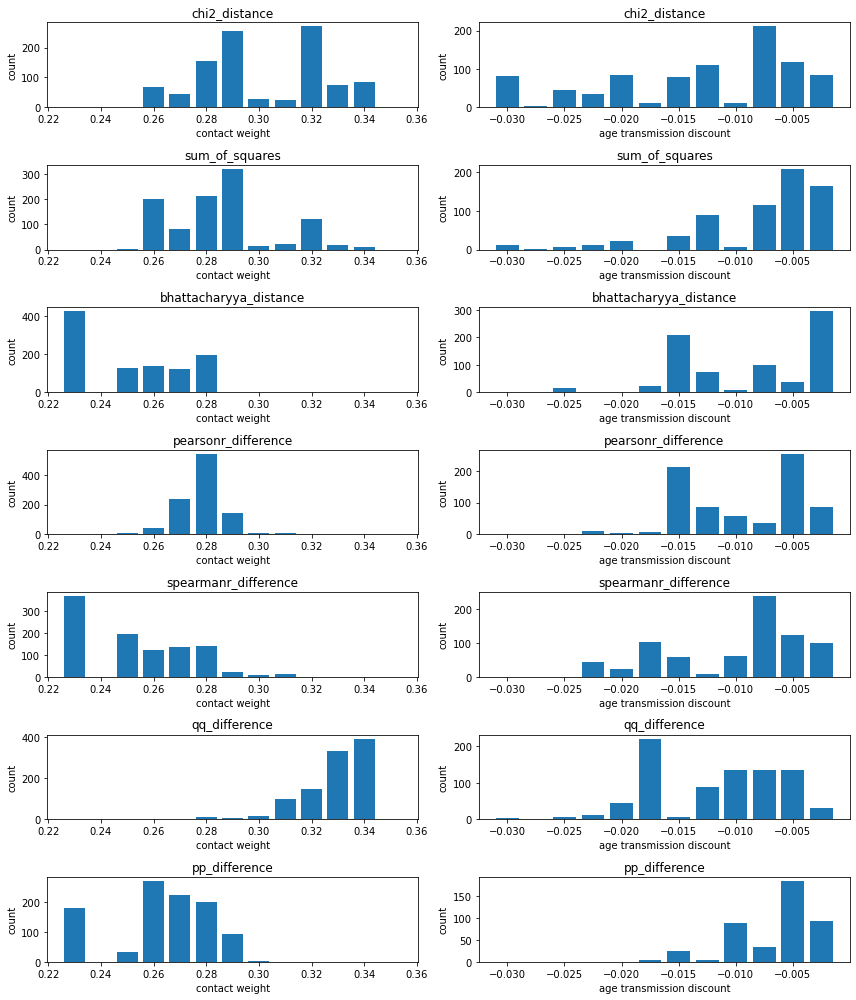

In [58]:
fig, axes = plt.subplots(len(distance_cols), 2, 
                         figsize=(12, 2 * len(distance_cols)))

for i, col in enumerate(distance_cols):
    ax = axes[i, :]
    ax[0].hist(opt_bs['contact_weight_' + col], rwidth=0.8, 
                 bins=np.arange(0.23, 0.37, 0.01), align='left')
    ax[0].set_xlabel('contact weight')
    ax[1].hist(opt_bs['age_transmission_discount_' + col], rwidth=0.8,
                 bins=np.arange(-0.03, 0.001, 0.0025), align='left')
    ax[1].set_xlabel('age transmission discount')
    for a in ax:
        a.set_title(col)
        a.set_ylabel('count')
        
fig.tight_layout()
plt.savefig('../../data/plots/calibration/distance_bootstrapping.pdf');

#### Figure S2: Optimum confidence intervals

In [46]:
uncertainties_cw = []
medians_cw = []
uncertainties_atd = []
medians_atd = []
for col in distance_cols:
    median = opt_bootstrap['contact_weight_' + col].median()
    mean = opt_bootstrap['contact_weight_' + col].mean()
    low = opt_bootstrap['contact_weight_' + col].quantile(0.025)
    high = opt_bootstrap['contact_weight_' + col].quantile(0.975)
    
    atd_median = opt_bootstrap['age_transmission_discount_' + col].median()
    atd_mean = opt_bootstrap['age_transmission_discount_' + col].mean()
    atd_low = opt_bootstrap['age_transmission_discount_' + col].quantile(0.025)
    atd_high = opt_bootstrap['age_transmission_discount_' + col].quantile(0.975)
    
    print('{}: contact weight {} [{}; {}] (mean {:1.4f}), atd {} [{}; {}]'\
          .format(col, median, low, high, mean, atd_median, atd_low, atd_high, atd_mean))
    
    uncertainties_cw.append(high - low)
    uncertainties_atd.append(atd_high - atd_low)
    medians_cw.append(median)
    medians_atd.append(atd_median)

chi2_distance: contact weight 0.3 [0.26; 0.35] (mean 0.3100), atd -0.0075 [-0.03; 0.0]
sum_of_squares: contact weight 0.3 [0.26; 0.34] (mean 0.2922), atd -0.005 [-0.0225; 0.0]
bhattacharyya_distance: contact weight 0.25 [0.24; 0.29] (mean 0.2571), atd -0.0025 [-0.0175; 0.0]
pearsonr_difference: contact weight 0.29 [0.26; 0.31] (mean 0.2840), atd -0.005 [-0.015; 0.0]
spearmanr_difference: contact weight 0.25 [0.23; 0.3] (mean 0.2551), atd -0.0075 [-0.0225; 0.0]
qq_difference: contact weight 0.34 [0.31; 0.35] (mean 0.3391), atd -0.01 [-0.02; 0.0]
pp_difference: contact weight 0.27 [0.24; 0.3] (mean 0.2673), atd 0.0 [-0.015; 0.0]


In [225]:
distance_cols = [
    'qq_difference',
    'pp_difference',
    'pearsonr_difference',
    'spearmanr_difference',
    'bhattacharyya_distance',
    'chi2_distance',
    'sum_of_squares',
]

dst = '../../data/calibration/simulation_results/'

bs_df = pd.DataFrame()
for col in distance_cols:
    median = opt_bootstrap['contact_weight_' + col].median()
    mean = opt_bootstrap['contact_weight_' + col].mean()
    low = opt_bootstrap['contact_weight_' + col].quantile(0.025)
    high = opt_bootstrap['contact_weight_' + col].quantile(0.975)
    
    median_atd = opt_bootstrap['age_transmission_discount_' + col].median()
    mean_atd = opt_bootstrap['age_transmission_discount_' + col].mean()
    low_atd = opt_bootstrap['age_transmission_discount_' + col].quantile(0.025)
    high_atd = opt_bootstrap['age_transmission_discount_' + col].quantile(0.975)
    
    bs_df = bs_df.append({
        'distance_measure':col,
        'cw_median':median,
        'cw_mean':mean,
        'cw_0.025':low,
        'cw_0.975':high,
        'atd_median':median_atd,
        'atd_mean':mean_atd,
        'atd_0.025':low_atd,
        'atd_0.975':high_atd
    }, ignore_index=True)
    
bs_df.to_csv(join(dst, 'bootstrapping_statistics.csv'), index=False)
    
bs_df

,atd_0.025,atd_0.975,atd_mean,atd_median,cw_0.025,cw_0.975,cw_mean,cw_median,distance_measure
0,-0.0200,0.0,-0.009640,-0.0100,0.31,0.35,0.33913,0.34,qq_difference
1,-0.0150,0.0,-0.002772,0.0000,0.24,0.30,0.26729,0.27,pp_difference
2,-0.0150,0.0,-0.007108,-0.0050,0.26,0.31,0.28398,0.29,pearsonr_difference
3,-0.0225,0.0,-0.007575,-0.0075,0.23,0.30,0.25513,0.25,spearmanr_difference
4,-0.0175,0.0,-0.006530,-0.0025,0.24,0.29,0.25709,0.25,bhattacharyya_distance
5,-0.0300,0.0,-0.011375,-0.0075,0.26,0.35,0.31005,0.30,chi2_distance
6,-0.0225,0.0,-0.005298,-0.0050,0.26,0.34,0.29221,0.30,sum_of_squares


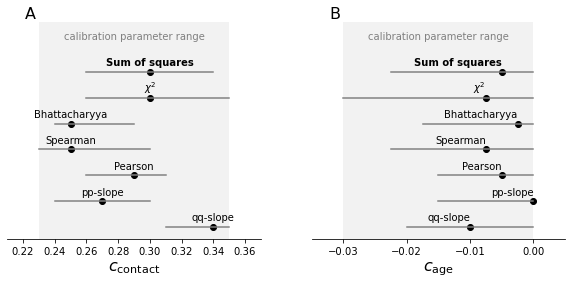

In [167]:
dst = '../../data/plots/calibration'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

distance_col_names = {
    'chi2_distance':'$\\chi^2$',
    'sum_of_squares':'Sum of squares',
    'bhattacharyya_distance':'Bhattacharyya',
    'pearsonr_difference':'Pearson',
    'spearmanr_difference':'Spearman',
    'pp_difference':'pp-slope',
    'qq_difference':'qq-slope'
}

y_factor = 1.5

for i, row in bs_df.iterrows():
    fontweight = 'normal'
    if row['distance_measure'] == 'sum_of_squares':
        fontweight = 'bold'
        
    axes[0].plot([row['cw_0.025'], row['cw_0.975']], 
                 [i * y_factor / 7, i * y_factor / 7], 
                 zorder=2, color=(0.5, 0.5, 0.5))
    axes[1].plot([row['atd_0.025'], row['atd_0.975']], 
                 [i * y_factor / 7, i * y_factor / 7],
                 zorder=2, color=(0.5, 0.5, 0.5))
    axes[0].text(row['cw_median'], i * y_factor / 7 + 0.05, 
                 distance_col_names[row['distance_measure']], ha='center',
                 fontweight=fontweight)
    axes[1].text(row['atd_median'], i * y_factor / 7 + 0.05, 
                 distance_col_names[row['distance_measure']], ha='right',
                 fontweight=fontweight)
    
axes[0].scatter(bs_df['cw_median'], 
                [i * y_factor / 7 for i in range(len(bs_df))], 
                zorder=2, color='k')
axes[1].scatter(bs_df['atd_median'], 
                [i * y_factor / 7 for i in range(len(bs_df))],
                zorder=2, color='k')

axes[0].set_xlim(contact_weights_fine[0] - 0.02,
                 contact_weights_fine[-1] + 0.02)
axes[1].set_xlim(age_transmission_discounts_fine[-1] - 0.005,
                 age_transmission_discounts_fine[0] + 0.005)

axes[0].set_xlabel('$c_\\mathrm{contact}$', fontsize=16)
axes[1].set_xlabel('$c_\\mathrm{age}$', fontsize=16)

for ax in axes:
    ax.set_ylim(-0.1, 1 * y_factor + 0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

x_span_cw = contact_weights_fine[-1] - contact_weights_fine[0]
y_span = 1 * y_factor + 2
rect_cw = patches.Rectangle((contact_weights_fine[0], -0.1), x_span_cw, y_span, 
                         edgecolor='none', facecolor=(0.95, 0.95, 0.95), zorder=1)
x_span_atd = age_transmission_discounts_fine[-1] - \
             age_transmission_discounts_fine[0]
rect_atd = patches.Rectangle((age_transmission_discounts_fine[0], -0.1), 
                              x_span_atd, y_span, edgecolor='none', 
                             facecolor=(0.95, 0.95, 0.95), zorder=1)
axes[0].add_patch(rect_cw)
axes[1].add_patch(rect_atd)
axes[0].text(contact_weights_fine[0] + x_span_cw / 2, 1 * y_factor + 0.05,
             'calibration parameter range', ha='center', color=(0.5, 0.5, 0.5))
axes[1].text(age_transmission_discounts_fine[0] + x_span_atd / 2, 1 * y_factor + 0.05,
             'calibration parameter range', ha='center', color=(0.5, 0.5, 0.5))

axes[1].set_xticks([-0.03, -0.02, -0.01, 0])

fig.text(0.15, 0.89, 'A', fontsize=16)
fig.text(0.572, 0.89, 'B', fontsize=16)

plt.savefig(join(dst, 'parameter_confidence_intervals.pdf'))

### Probability of no follow-up cases

In [35]:
for school_type in school_types:
    print(school_type)
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
            .format(school_type, 0.26, 0.26, 0.0)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    no_follow_up = len(ensemble_results[ensemble_results['infected_total'] == 0])
    N_runs = len(ensemble_results)
    print('no follow-up cases in {}/{} runs ({:1.2f}%)'\
          .format(no_follow_up, N_runs, no_follow_up/N_runs * 100))
    print()

primary
no follow-up cases in 2504/4000 runs (62.60%)

primary_dc
no follow-up cases in 2505/4000 runs (62.62%)

lower_secondary
no follow-up cases in 1779/4000 runs (44.47%)

lower_secondary_dc
no follow-up cases in 2219/4000 runs (55.47%)

upper_secondary
no follow-up cases in 1766/4000 runs (44.15%)

secondary
no follow-up cases in 1591/4000 runs (39.77%)



### Analyze the fine grid search for distances between student- and teacher distributions

Note: this is an additional analysis that is not included in the paper.

#### Calculate distance metrics

In [31]:
# calculate the various distribution distances between the simulated and
# observed outbreak size distributions
src = '../../data/calibration/simulation_results/ensembles_fine_ensemble_distributions'

results_fine = pd.DataFrame()
for i, ep in enumerate(screening_params):
    _, school_type, icw, fcw, atd = ep
    if i % 100 == 0:
        print('{}/{}'.format(i, len(screening_params)))
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
        .format(school_type, icw, fcw, atd)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    row = cf.calculate_distances_two_distributions(ensemble_results, school_type,
            icw, fcw, atd, outbreak_sizes, group_distributions)
    
    results_fine = results_fine.append(row, ignore_index=True)

0/1014
100/1014
200/1014
300/1014
400/1014
500/1014
600/1014
700/1014
800/1014
900/1014
1000/1014


In [34]:
results_fine = results_fine.sort_values(by=['school_type',
                'intermediate_contact_weight', 'age_transmission_discount'])
results_fine = results_fine.reset_index(drop=True)

for agent_type in ['student', 'teacher']:
    results_fine['chi2_distance_{}_weighted'.format(agent_type)] = \
        results_fine['chi2_distance_{}'.format(agent_type)]
    for i, row in results_fine.iterrows():
        st = row['school_type']
        weight = counts.loc[st, 'weight']
        error = row['chi2_distance_{}'.format(agent_type)]
        results_fine.loc[i, 'chi2_distance_{}_weighted'.format(agent_type)] \
            = error * weight

#### Aggretage results for teacher and student distributions

In [35]:
agg_results_fine = results_fine\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount'])\
    .sum()

for agent_type in ['student', 'teacher']:
    print(agent_type)
    opt_fine = agg_results_fine.loc[\
            agg_results_fine['chi2_distance_{}_weighted'.format(agent_type)]\
                                            .idxmin()].name
    opt_contact_weight_fine = opt_fine[0]
    opt_age_transmission_discount_fine = opt_fine[1]

    print('optimal grid search parameter combination:')
    print('\t contact weight: {:1.3f}'\
          .format(opt_contact_weight_fine))
    print('\t age transmission discount: {:1.4f}'\
          .format(opt_age_transmission_discount_fine))
    print()

student
optimal grid search parameter combination:
	 contact weight: 0.320
	 age transmission discount: 0.0000

teacher
optimal grid search parameter combination:
	 contact weight: 0.350
	 age transmission discount: 0.0000



In [36]:
agent_type_images = {}
for agent_type in ['student', 'teacher']:
    img_fine = np.zeros((len(contact_weights_fine),
                    len(age_transmission_discounts_fine)))
    for i, cw in enumerate(contact_weights_fine):
        for j, atd in enumerate(age_transmission_discounts_fine):
            cw = round(cw, 2)
            atd = round(atd, 4)
            try:
                img_fine[i, j] = agg_results_fine\
                    .loc[cw, atd]['chi2_distance_{}_weighted'.format(agent_type)]
            except KeyError:
                print(atd)
                img_fine[i, j] = np.nan
    agent_type_images[agent_type] = img_fine

In [37]:
agg_results_fine_schools = results_fine\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount', 'school_type'])\
    .sum()

#### Plot results for teacher and student distributions

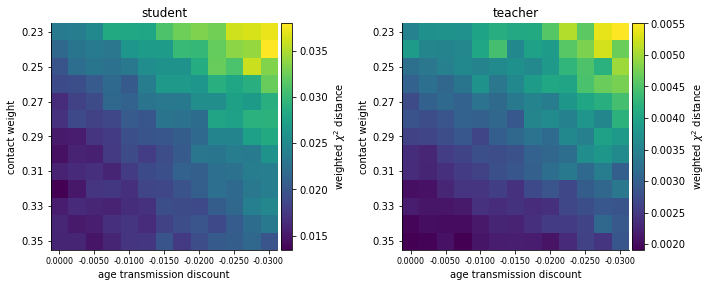

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

for ax, agent_type in zip(axes.flatten(), ['student', 'teacher']):
    img_fine = agent_type_images[agent_type]
    im = ax.imshow(img_fine)
    ax.set_yticks(range(len(contact_weights_fine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_fine[::2]])
    ax.set_xticks(range(len(age_transmission_discounts_fine))[::2])
    ax.set_xticklabels(['{:1.4f}'.format(atd) for \
                        atd in age_transmission_discounts_fine[::2]],
                        fontsize=8)
    ax.set_title(agent_type)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('weighted $\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('contact weight')
    ax.set_xlabel('age transmission discount')

fig.tight_layout()
plt.savefig('../../data/plots/calibration/groups_heatmap.pdf')

#### Aggregate results for individual school types

In [39]:
agent_type_images_schools = {st:{} for st in school_types}


for st in school_types:
    for agent_type in ['student', 'teacher']:
        img_fine = np.zeros((len(contact_weights_fine),
                        len(age_transmission_discounts_fine)))
        for i, cw in enumerate(contact_weights_veryfine):
            for j, atd in enumerate(age_transmission_discounts_fine):
                cw = round(cw, 2)
                atd = round(atd, 4)
                try:
                    img_fine[i, j] = agg_results_fine_schools\
                        .loc[cw, atd, st]['chi2_distance_{}'.format(agent_type)]
                except KeyError:
                    print(atd)
                    img_veryfine[i, j] = np.nan
        agent_type_images_schools[st][agent_type] = img_fine

#### Contribution of primary schools to the distance metrics

In [50]:
d_primary = agent_type_images_schools['primary']['student'].mean() * \
    counts.loc['primary']['weight']

d_primary_dc = agent_type_images_schools['primary_dc']['student'].mean() * \
    counts.loc['primary_dc']['weight']

d_lower_secondary = agent_type_images_schools['lower_secondary']['student'].mean() * \
    counts.loc['lower_secondary']['weight']

d_lower_secondary_dc = agent_type_images_schools['lower_secondary_dc']['student'].mean() * \
    counts.loc['lower_secondary_dc']['weight']

d_upper_secondary = agent_type_images_schools['upper_secondary']['student'].mean() * \
    counts.loc['upper_secondary']['weight']

d_secondary = agent_type_images_schools['secondary']['student'].mean() * \
    counts.loc['secondary']['weight']

In [54]:
d_primary_ratio = (d_primary + d_primary_dc) / (d_primary + d_primary_dc + \
    d_lower_secondary +  d_lower_secondary_dc + d_upper_secondary + d_secondary)

print('Primary and primary_dc schools contribute {:1.1f}% to the overall Chi² distance.'\
         .format(d_primary_ratio * 100))

Primary and primary_dc schools contribute 60.8% to the overall Chi² distance.


#### Plot results for individual school types

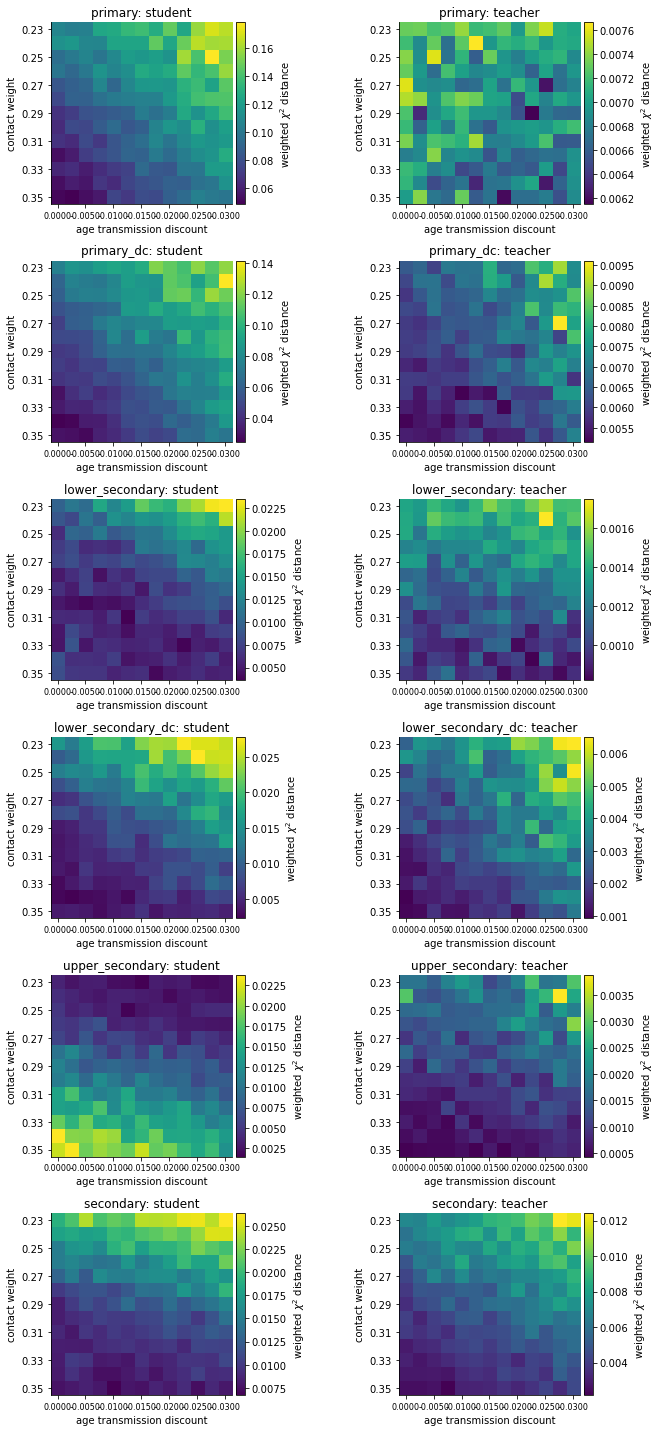

In [55]:
fig, axes = plt.subplots(6, 2, figsize=(10, 20))
plot_types = [(st, at) for st in school_types for at in ['student', 'teacher']]

for ax, pt in zip(axes.flatten(), plot_types):
    school_type, agent_type = pt
    
    img_fine = agent_type_images_schools[school_type][agent_type]
    im = ax.imshow(img_fine)
    ax.set_yticks(range(len(contact_weights_fine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_fine[::2]])
    ax.set_xticks(range(len(age_transmission_discounts_fine))[::2])
    ax.set_xticklabels(['{:1.4f}'.format(atd) for \
                        atd in age_transmission_discounts_fine[::2]],
                        fontsize=8)
    ax.set_title('{}: {}'.format(school_type, agent_type))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('weighted $\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('contact weight')
    ax.set_xlabel('age transmission discount')

fig.tight_layout()
plt.savefig('../../data/plots/calibration/groups_schools_heatmap.pdf')